# Oxygen Evals: Bottom Timeseries in Saanich Inlet, Satrait of Georgia Center and East

In [3]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean.cm as cm
import copy

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

import datetime as dt
import arrow
import copy
import math
import matplotlib.dates as mdates
import gsw
from mpl_toolkits.basemap import Basemap

In [4]:
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc', mask_and_scale=False)

depthb = meshb.variables['gdept_0'][:]


In [5]:
# ONC observation
# Obs cordonates (Saanich Inlet) : 48.651366°N, -123.486358°W, 93m
# Obs cordonates: SoG Center: 49.039467°N, -123.425033°W, 305m ; SoG Est: 49.042586°N,  -123.316579°W, 166m
df_ctd = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/SI_Venus_Inst_Platform/Temperature_SA_Sigmat_CTDA_20180101_20191231_clean_avg1day_edit.csv')
df_rko = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/SI_Venus_Inst_Platform/Temperature_Oxygen_RinkoSensor_20180101_20191231_clean_avg1day_edit.csv')
df_sogC = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/Oxygen_20180101_20191231_clean_avg1day_SoGCenter_edit.csv')
df_sogE = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/Oxygen_20180101_20191231_clean_avg1day_SoGEst_edit.csv')
df_ctd.head()

,Time UTC (yyyy-mm-ddThh:mm:ss.fffZ),Temperature (C),Practical Salinity (psu),Sigma-t (kg/m3)
0,2018-01-01T12:00:00.000Z,9.585932539,30.963502805,23.86826656
1,2018-01-02T12:00:00.000Z,9.577705381,30.934944818,23.847273839
2,2018-01-03T12:00:00.000Z,9.581542369,30.946245712,23.855487199
3,2018-01-04T12:00:00.000Z,9.578901597,30.931631389,23.844496877
4,2018-01-05T12:00:00.000Z,9.577732847,30.924635069,23.839219606


In [6]:
df_rko

,Time UTC (yyyy-mm-ddThh:mm:ss.fffZ),Temperature (C),Oxygen Concentration Corrected (ml/l)
0,2018-01-01T12:00:00.000Z,9.600959017,0.507372272
1,2018-01-02T12:00:00.000Z,9.593706987,0.634645594
2,2018-01-03T12:00:00.000Z,9.595493833,0.566978259
3,2018-01-04T12:00:00.000Z,9.594484038,0.608590795
4,2018-01-05T12:00:00.000Z,9.594025563,0.615223959
...,...,...,...
722,2019-12-26T12:00:00.000Z,9.609252352,1.215274067
723,2019-12-27T12:00:00.000Z,9.654206418,0.925476382
724,2019-12-28T12:00:00.000Z,9.624187552,1.156520922
725,2019-12-29T12:00:00.000Z,9.591318718,1.275286609


In [7]:
# Convert objet dataframe to int
df_sogC['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_sogC['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_sogE['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_sogE['Oxygen Concentration Corrected (ml/l)'], errors='coerce')

df_rko['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_rko['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_rko['Temperature (C)'] = pd.to_numeric(df_rko['Temperature (C)'], errors='coerce')
df_ctd['Temperature (C)'] = pd.to_numeric(df_ctd['Temperature (C)'], errors='coerce')
df_ctd['Practical Salinity (psu)'] = pd.to_numeric(df_ctd['Practical Salinity (psu)'], errors='coerce')
df_ctd['Sigma-t (kg/m3)'] = pd.to_numeric(df_ctd['Sigma-t (kg/m3)'], errors='coerce')
time = np.arange(dt.datetime(2018,1,1), dt.datetime(2019,12,31), dt.timedelta(days=1)).astype(dt.datetime)

In [8]:
# Obs variables
oxy_sogC = df_sogC['Oxygen Concentration Corrected (ml/l)']
oxy_sogE = df_sogE['Oxygen Concentration Corrected (ml/l)']
oxy_obs = df_rko['Oxygen Concentration Corrected (ml/l)']
sal_obs = gsw.SR_from_SP(df_ctd['Practical Salinity (psu)']) # from practical to ref salinity (g/kg)
tem_obs = df_ctd['Temperature (C)']
tem_obs2 = df_rko['Temperature (C)']
sig_obs = df_ctd['Sigma-t (kg/m3)']

In [9]:
# SalishSeaCast zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0, Z2eff=0
df_chemTd0 = xr.open_mfdataset('/data/atall/MEOPAR/SalishSeaCast/results/SalishSea_1d_20180901_20181130_chem_T.nc')

# SalishSea_oxy test zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.45, no Bremin
df_chemTd1 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_DRef05/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.45, without Bremin
df_chemTd2 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_sink/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.35
df_chemTd3 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_Bremin010/SalishSea_1d_20180901_20181130_chem_T.nc')
df_chemTd3b = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_Bremin010_restartO2/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.35
df_chemTd4 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_Bremin035/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.70
df_chemTd5 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_Bremin070/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.35
df_chemTd6 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_PSR0001Bremin035/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.50
df_chemTd7 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_PSR0001Bremin050/SalishSea_1d_20180901_20181130_chem_T.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.60, PON_and_DON_remin_rate = 2.56e-7
df_chemTd8 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/sep_nov18/modif_PSR0001Bremin060_PDONrem_e12/SalishSea_1d_20180901_20181130_chem_T.nc')

In [10]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
tmask = meshmask.tmask
#tmask = tmask.rename({'z' : 'depth', 'y': 'gridY', 'x': 'gridX'})
mbathy = meshmask.mbathy
#grid_lons_lats

In [11]:
j_SI = grid_lons_lats.jj.sel(lats=48.651366, lons=-123.486358, method='nearest') # 93 m (Obs)
i_SI = grid_lons_lats.ii.sel(lats=48.651366, lons=-123.486358, method='nearest')
j_SoG = grid_lons_lats.jj.sel(lats=49.039467, lons=-123.425033, method='nearest') # 305 m (Obs)
i_SoG = grid_lons_lats.ii.sel(lats=49.039467, lons=-123.425033, method='nearest')
j_SoGE = grid_lons_lats.jj.sel(lats=49.042586, lons=-123.316579, method='nearest') # 305 m (Obs)
i_SoGE = grid_lons_lats.ii.sel(lats=49.042586, lons=-123.316579, method='nearest')
print((j_SI.item(),i_SI.item()), (j_SoG.item(),i_SoG.item()), (j_SoGE.item(),i_SoGE.item()))

(353, 209) (423, 266) (416, 283)


In [12]:
print(bathyb.variables['Bathymetry'][j_SI, i_SI], bathyb.variables['Bathymetry'][j_SoG, i_SoG], bathyb.variables['Bathymetry'][j_SoGE, i_SoGE])

103.875 305.8125 163.4375


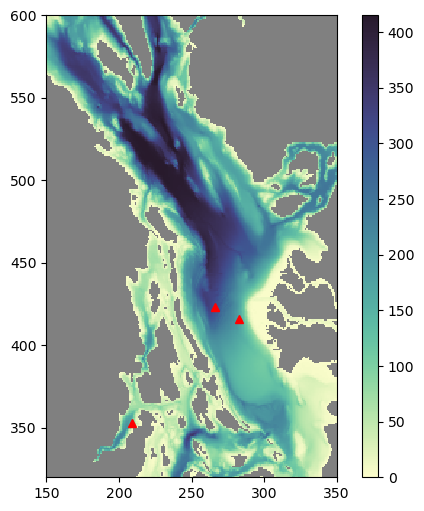

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
im = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=0, vmax=415)
ax.plot(i_SI,j_SI,'r^')
ax.plot(i_SoG,j_SoG,'r^')
ax.plot(i_SoGE,j_SoGE,'r^')
ax.set_xlim([150, 350])
ax.set_ylim([320, 600])
viz_tools.set_aspect(ax);
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


Text(0.5, 1.0, '')

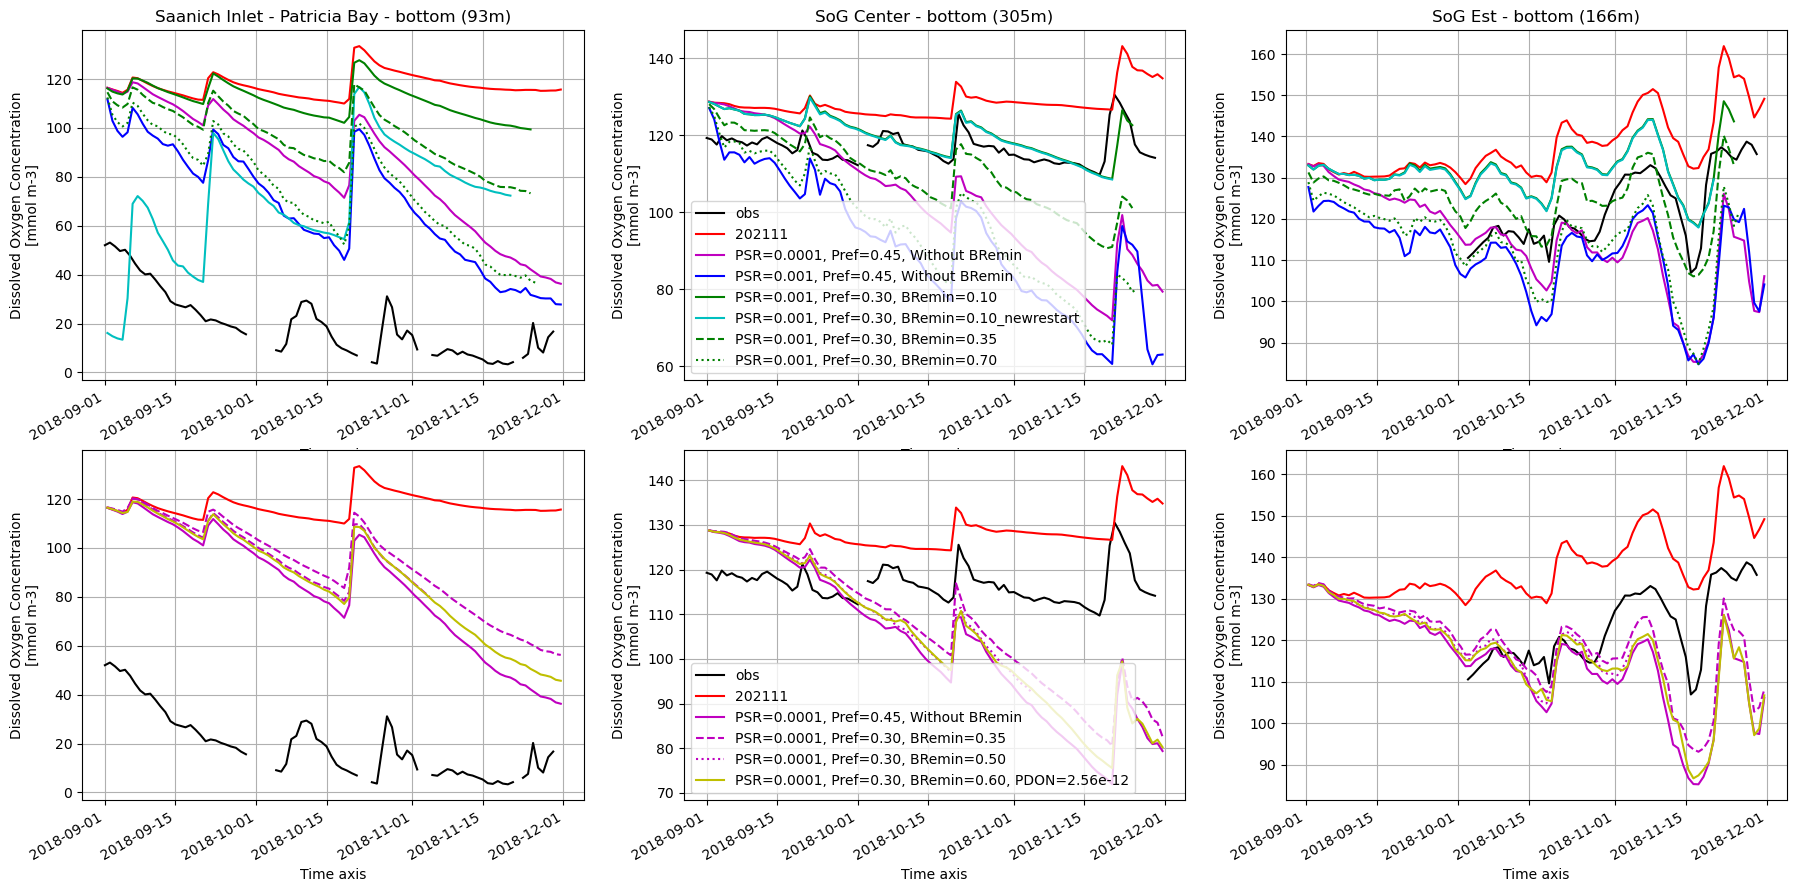

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax[0,0].plot(time[243:333],oxy_obs[243:333] * 44.661, 'k',label='obs')
ax[1,0].plot(time[243:333],oxy_obs[243:333] * 44.661, 'k',label='obs')

df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='r',label='202111')
df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time_counter", color='r',label='202111')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd2['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='b',label='PSR=0.001, Pref=0.45, Without BRemin')
df_chemTd3['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='g',label='PSR=0.001, Pref=0.30, BRemin=0.10')
df_chemTd3b['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='c',label='PSR=0.001, Pref=0.30, BRemin=0.10_newrestart')
df_chemTd4['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='g',linestyle='dashed',label='PSR=0.001, Pref=0.30, BRemin=0.35')
df_chemTd5['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='g',linestyle='dotted',label='PSR=0.001, Pref=0.30, BRemin=0.70')
df_chemTd6['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time_counter", color='m',linestyle='dashed',label='PSR=0.0001, Pref=0.30, BRemin=0.35')
df_chemTd7['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time_counter", color='m',linestyle='dashed',label='PSR=0.0001, Pref=0.30, BRemin=0.50')
df_chemTd8['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time_counter", color='y',label='PSR=0.0001, Pref=0.30, BRemin=0.60, PDON=2.56e-12')

ax[0,1].plot(time[243:333],oxy_sogC[243:333] * 44.661, 'k', label='obs')
ax[0,2].plot(time[243:333],oxy_sogE[243:333] * 44.661, 'k', label='obs')
ax[1,1].plot(time[243:333],oxy_sogC[243:333] * 44.661, 'k', label='obs')
ax[1,2].plot(time[243:333],oxy_sogE[243:333] * 44.661, 'k', label='obs')
df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='r',label='202111')
df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='r',label='202111')
df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time_counter", color='r',label='202111')
df_chemTd0['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time_counter", color='r',label='202111')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd1['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time_counter", color='m',label='PSR=0.0001, Pref=0.45, Without BRemin')
df_chemTd2['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='b',label='PSR=0.001, Pref=0.45, Without BRemin')
df_chemTd2['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='b',label='PSR=0.001, Pref=0.45, Without BRemin')
df_chemTd3['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='g',label='PSR=0.001, Pref=0.30, BRemin=0.10')
df_chemTd3b['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='c',label='PSR=0.001, Pref=0.30, BRemin=0.10_newrestart')
df_chemTd3['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='g',label='PSR=0.001, Pref=0.30, BRemin=0.10')
df_chemTd3b['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='c',label='PSR=0.001, Pref=0.30, BRemin=0.10_newrestart')
df_chemTd4['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='g',linestyle='dashed',label='PSR=0.001, Pref=0.30, BRemin=0.35')
df_chemTd4['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='g',linestyle='dashed',label='PSR=0.001, Pref=0.30, BRemin=0.35')
df_chemTd5['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time_counter", color='g',linestyle='dotted',label='PSR=0.001, Pref=0.30, BRemin=0.70')
df_chemTd5['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time_counter", color='g',linestyle='dotted',label='PSR=0.001, Pref=0.30, BRemin=0.70')
df_chemTd6['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time_counter", color='m',linestyle='dashed',label='PSR=0.0001, Pref=0.30, BRemin=0.35')
df_chemTd6['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time_counter", color='m',linestyle='dashed',label='PSR=0.0001, Pref=0.30, BRemin=0.35')
df_chemTd7['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time_counter", color='m',linestyle='dotted',label='PSR=0.0001, Pref=0.30, BRemin=0.50')
df_chemTd7['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time_counter", color='m',linestyle='dotted',label='PSR=0.0001, Pref=0.30, BRemin=0.50')
df_chemTd8['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time_counter", color='y',label='PSR=0.0001, Pref=0.30, BRemin=0.60, PDON=2.56e-12')
df_chemTd8['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time_counter", color='y',label='PSR=0.0001, Pref=0.30, BRemin=0.60, PDON=2.56e-12')


ax[0,0].grid()
ax[1,0].grid()
#ax[0].legend()
ax[0,1].grid()
ax[1,1].grid()
ax[0,1].legend()
ax[1,1].legend()
ax[0,2].grid()
ax[1,2].grid()
#ax[2].legend()
ax[0,0].set_title('Saanich Inlet - Patricia Bay - bottom (93m)')
ax[0,1].set_title('SoG Center - bottom (305m)')
ax[0,2].set_title('SoG Est - bottom (166m)')
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,2].set_title('')
#fig.suptitle('Model, PON sinking rate = 0.0001')
#fig.savefig('../figures_WQM-KC/DO_Obs-202111-2024XX-2024XXc-2024XXb-2024XXd_PatriciaBay.png',dpi = 300)